# CS146 Assignment 3 - Using Stan & other exercises

## 1. Implement models in Stan (required)

Implement each of the models below using Stan and produce the results or plots requested for each model. You have seen each of these models before in class.

The goal of this exercise is to learn how to implement different types of parameters, likelihood functions, and prior distributions using Stan. Stan always generates samples for estimating posterior distributions, while we used conjugate distributions in class. Check that your results from Stan’s samples match the results we computed in class.

## First Task: Call center data set — exponential likelihood with a gamma prior. 
Estimate the number of calls per minute for the 13th hour of the call center data set.

Results to compute:

*   Posterior 98% confidence interval over λ (check that it matches results in the solution notebook below)
*   Histogram of posterior λ samples

In [0]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

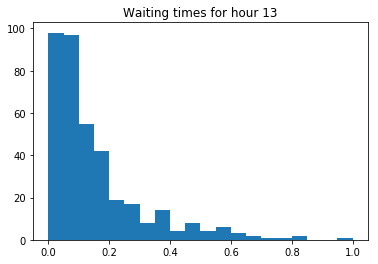

In [3]:
# Loading the data
waiting_times_day = np.loadtxt("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00124343-8397/call-center.csv")

# To process the data into 24-hour intervals, we first make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Since we are only looking at the 13th hour, we can extract that from the array.

hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]

# Plot a histogram to visualize the data

plt.hist(waiting_times_hour, bins=20)
plt.title('Waiting times for hour %i' % hour_index)
plt.show()

In [0]:
# For Stan we provide all known quantities as data, namely the observed data
# and our prior hyperparameters.
call_center_data = {
    'thirteen':{
      'prior_alpha': 1,  # fixed prior hyperparameters for the
      'prior_beta': 0.25,   # beta distribution
      'waiting_times': waiting_times_hour,  # the data for hour 13
      'num_calls': len(waiting_times_hour) # how many calls received in that hour 
    }
}

In [0]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_calls;  // number of calls in hour 13
    real<lower=0> waiting_times[num_calls];  // wait time of each call
    real<lower=0> prior_alpha;  // fixed prior hyperparameter
    real<lower=0> prior_beta;   // fixed prior hyperparameter
}


// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0> lambda;  // the rate lambda, which is the only
                              // parameter of the exponential likelihood
}


// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    lambda ~ gamma(prior_alpha, prior_beta);  // modelling our gamma prior 
                                              // distribution
    for(i in 1:num_calls) {
        waiting_times[i] ~ exponential(lambda); // here, we are multiplying the 
                                            // lambda by each of the likelihood 
                                            // data with the assumption that the
                                            // likelihood is an exponential
                                            // distribution
    }
}
"""

In [6]:
# Compiling the Stan Model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8e63f000150bad9de257ef3cef5ba57 NOW.


In [0]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the waiting
# times in hour thirteen.

stan_results = stan_model.sampling(data=call_center_data['thirteen'])

In [8]:
# Printing out the results of the stan model.

print(stan_results)

Inference for Stan model: anon_model_c8e63f000150bad9de257ef3cef5ba57.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lambda   6.37  8.7e-3   0.33   5.74   6.14   6.36   6.59   7.02   1416    1.0
lp__   324.41    0.02   0.73 322.36 324.26 324.69 324.87 324.92   1649    1.0

Samples were drawn using NUTS at Sat Oct 19 18:39:42 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
# Since we are looking for the posterior 98% confidence interval over λ, we 
# have to change the parameters for the lambda CI a little bit

print(stan_results.stansummary(pars=['lambda'], probs=[0.01, 0.99]))

Inference for Stan model: anon_model_c8e63f000150bad9de257ef3cef5ba57.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd     1%    99%  n_eff   Rhat
lambda   6.37  8.7e-3   0.33   5.63   7.15   1416    1.0

Samples were drawn using NUTS at Sat Oct 19 18:39:42 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% confidence interval for lambda: [5.63079245 7.14995557]


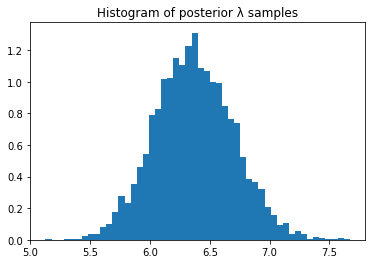

In [10]:
# Plotting the histogram of posterior λ samples

posterior_samples = stan_results.extract()
plt.hist(posterior_samples['lambda'], bins=50, density=True)
plt.title('Histogram of posterior λ samples')
print(
    "Posterior 95% confidence interval for lambda:",
    np.percentile(posterior_samples['lambda'], [1, 99]))
plt.show()

## Second Task: Normal likelihood with normal-inverse-gamma prior.

Results to compute:


*   95% posterior confidence intervals for the mean $μ$ and variance $σ^2$ of the data.
*   Take 10 samples from your posterior over $μ$ and $σ^2$ and plot the normal distributions corresponding to them. See Task 3 in the solutions below — you should produce a plot similar to the one you find there.

### Computing the 95% posterior confidence intervals for the mean  $μ$  and variance  $σ^2$  of the data.

In [11]:
# Load the data set
datum = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])

# Check the number of data points in the data set
print(f"There are {len(datum)} data points, with the upper boundary at {max(datum)}, and the lower boundary at {min(datum)}.")

There are 200 data points, with the upper boundary at 7.27215002907876, and the lower boundary at -1.90805399279409.


In [0]:
# Same as earlier, we define the data that's given to us
norminvgamma_data = {
    'dataset':{
        'mu_0': 0,
        'nu_0': 0.054,
        'alpha_0': 1.12,
        'beta_0': 0.4,
        'datum': datum,
        'num_data': len(datum) 
    }
}

In [0]:
stan_code_2 = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_data;  // the index for each data point
    real datum[num_data];  // the value of each data point
    real<lower=0> mu_0;  // fixed prior hyperparameter
    real<lower=0> nu_0;   // fixed prior hyperparameter
    real<lower=0> alpha_0;   // fixed prior hyperparameter
    real<lower=0> beta_0;   // fixed prior hyperparameter
}


// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real x; // x is the mean of the data
    real sigma2; // sigma2 is the variance of the data
}


// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    sigma2 ~ inv_gamma(alpha_0, beta_0); // The sigma is modeled with an inverse
                                        // gamma distribution
    x ~ normal(mu_0, sqrt(sigma2 / nu_0)); // The mean, x, is modeled with a 
                                          //normal distribution

    for(i in 1:num_data) {
        datum[i] ~ normal(x, sqrt(sigma2)); // Here, we are multiplying all the data 
                                     // points in the likelihood distribution
                                     // by the norminvgamma prior. It is crucial to 
                                     // use square root for the sigma2 term, since 
                                     // Stan uses the standard deviation instead of 
                                     // the variance to build the posterior hyperparameters.
    }
}
"""

In [14]:
# Compiling the Stan Model - here, we are giving the Stan model a different name
# since it's a different model from the one we created earlier.

stan_model_2 = pystan.StanModel(model_code=stan_code_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2776f88df1dba30557bb10265741b913 NOW.


In [0]:
# Fit the model to the data.

stan_results_2 = stan_model_2.sampling(data=norminvgamma_data['dataset'])

In [16]:
# Printing out the results of the stan model.

print(stan_results_2)

Inference for Stan model: anon_model_2776f88df1dba30557bb10265741b913.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x        3.06  2.4e-3   0.13    2.8   2.97   3.07   3.15   3.32   3224    1.0
sigma2   3.62  6.2e-3   0.37   2.99   3.36    3.6   3.86    4.4   3412    1.0
lp__   -234.5    0.02   1.01 -237.2 -234.9 -234.2 -233.7 -233.5   1874    1.0

Samples were drawn using NUTS at Sat Oct 19 18:40:59 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [17]:
# Since we are looking for the posterior 95% confidence interval over λ, we 
# have to change the parameters for the lambda CI a little bit

print(stan_results_2.stansummary(pars=['x', 'sigma2'], probs=[0.025, 0.975]))

Inference for Stan model: anon_model_2776f88df1dba30557bb10265741b913.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        3.06  2.4e-3   0.13    2.8   3.32   3224    1.0
sigma2   3.62  6.2e-3   0.37   2.99    4.4   3412    1.0

Samples were drawn using NUTS at Sat Oct 19 18:40:59 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Here, we can see that both the 95% CI values of $x$ (the mean) and the $\sigma^2$ matches the one that we got in our class activity. It was crucial though that we added a square root for the sigma2 term in the model part of the Stan code, since Stan uses the standard deviation instead of the variance to build the posterior hyperparameters.

### Plotting the normal distributions corresponding to the 10 samples from the posterior over  $μ$  and  $σ^2$

In [0]:
# Now, we have to extract 10 samples of x and sigma2 from the new stan results. 

x_values = stan_results_2.extract('x')
sigma2_values = stan_results_2.extract('sigma2')
x_samples = x_values['x'][np.random.choice(range(4000), 10)]
sigma2_samples = sigma2_values['sigma2'][np.random.choice(range(4000), 10)]

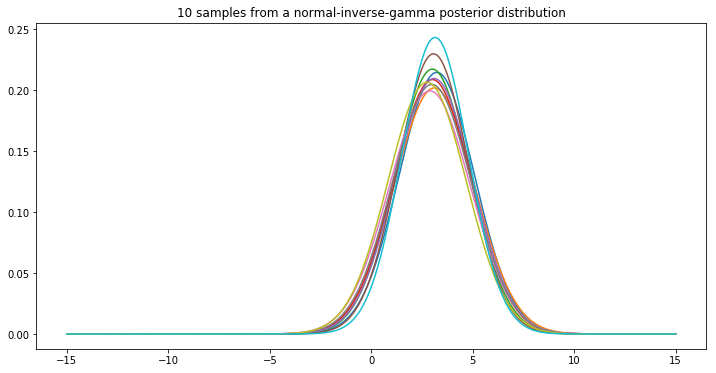

95% prior confidence intervals:
x: [2.784, 3.213]
σ²: [2.762, 3.980]


In [19]:
# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(10):
    plot_y = sts.norm.pdf(plot_x, loc=x_samples[i], scale=np.sqrt(sigma2_samples[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % 10)
plt.show()

print('95% prior confidence intervals:')
print('x: [%.3f, %.3f]' % (
    np.percentile(x_samples, 2.5),
    np.percentile(x_samples, 97.5)))
print('σ²: [%.3f, %.3f]' % (
    np.percentile(sigma2_samples, 2.5),
    np.percentile(sigma2_samples, 97.5)))

## Third task: Log-normal HRTEM data. 
Normal likelihood log-transformed data and using a normal-inverse-gamma prior.

Results to compute:

*   95% posterior confidence intervals for the $μ$ and variance $σ^2$ of the log-transformed data. (Should match results under Task 3 of the solutions.)
*   Take 10 samples from your posterior over $μ$ and $σ^2$ and plot the log-normal distributions corresponding to them. See Task 5 in the solutions below — you should produce a plot similar the one you find there, but with 10 pdfs rather than one.

In [20]:
# Loading the data
hrtem_data = np.loadtxt("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv")

# Check the number of data points in the data set
print(f"There are {len(hrtem_data)} data points, with the upper boundary at {max(hrtem_data)}, and the lower boundary at {min(hrtem_data)}.")

There are 500 data points, with the upper boundary at 28.9425775960553, and the lower boundary at 1.05182743421756.


In [0]:
# Same as earlier, we define the data that's given to us
hrtem = {
    'dataset':{
        'mu_0': 2.3,
        'nu_0': 0.1,
        'alpha_0': 2,
        'beta_0': 5,
        'datum': hrtem_data,
        'num_data': len(hrtem_data) 
    }
}

In [0]:
stan_code_3 = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_data;  // the index for each data point
    real datum[num_data];  // the value of each data point
    real<lower=0> mu_0;  // fixed prior hyperparameter
    real<lower=0> nu_0;   // fixed prior hyperparameter
    real<lower=0> alpha_0;   // fixed prior hyperparameter
    real<lower=0> beta_0;   // fixed prior hyperparameter
}


// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real x; // x is the mean of the data
    real sigma2; // sigma2 is the variance of the data
}


// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    sigma2 ~ inv_gamma(alpha_0, beta_0); // The sigma is modeled with an inverse
                                        // gamma distribution
    x ~ normal(mu_0, sqrt(sigma2 / nu_0)); // The mean, x, is modeled with a 
                                          //normal distribution

    for(i in 1:num_data) {
        datum[i] ~ lognormal(x, sqrt(sigma2)); // Here, we are multiplying all the data 
                                     // points in the likelihood distribution
                                     // by the norminvgamma prior. It is crucial to 
                                     // use square root for the sigma2 term, since 
                                     // Stan uses the standard deviation instead of 
                                     // the variance to build the posterior hyperparameters.
    }
}
"""

In [26]:
# Compiling the Stan Model - here, we are giving the Stan model a different name
# since it's a different model from the one we created earlier.

stan_model_3 = pystan.StanModel(model_code=stan_code_3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_89d8ba6932a303460740b320116a8502 NOW.


In [0]:
# Fit the model to the data.

stan_results_3 = stan_model_3.sampling(data=hrtem['dataset'])

In [28]:
# Printing out the results of the stan model.

print(stan_results_3)

Inference for Stan model: anon_model_89d8ba6932a303460740b320116a8502.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x        1.89  5.7e-4   0.03   1.83   1.87   1.89   1.91   1.96   3314    1.0
sigma2    0.5  5.3e-4   0.03   0.44   0.47   0.49   0.52   0.56   3360    1.0
lp__   -75.34    0.02   0.98 -77.89 -75.81 -75.04 -74.62 -74.33   1792    1.0

Samples were drawn using NUTS at Sat Oct 19 18:46:13 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [29]:
# Parsing the posterior 95% confidence interval over λ and sigma2

print(stan_results_3.stansummary(pars=['x', 'sigma2'], probs=[0.025, 0.975]))

Inference for Stan model: anon_model_89d8ba6932a303460740b320116a8502.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x        1.89  5.7e-4   0.03   1.83   1.96   3314    1.0
sigma2    0.5  5.3e-4   0.03   0.44   0.56   3360    1.0

Samples were drawn using NUTS at Sat Oct 19 18:46:13 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Once again, we can see that both the 95% CI values of $x$ (the mean) and the $\sigma^2$ matches the one that we got in our class activity. It was crucial again that we added a square root for the sigma2 term in the model part of the Stan code, since Stan uses the standard deviation instead of the variance to build the posterior hyperparameters.

In [0]:
# Now, we have to extract 10 samples of x and sigma2 from the stan results. 

x_values = stan_results_3.extract('x')
sigma2_values = stan_results_3.extract('sigma2')
x_samples = x_values['x'][:10]
sigma2_samples = sigma2_values['sigma2'][:10]

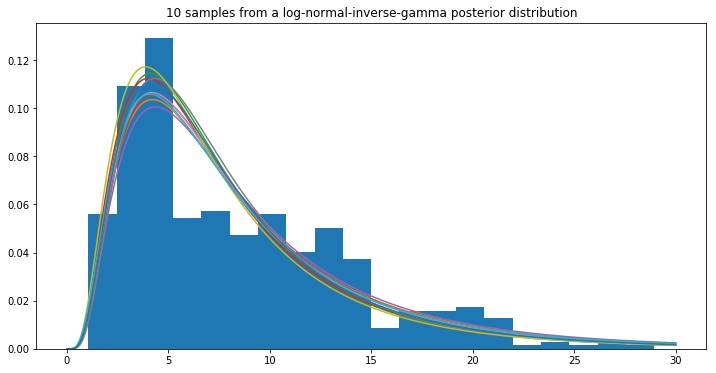

95% prior confidence intervals:
x: [1.842, 1.967]
σ²: [0.438, 0.508]


In [31]:
# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
plt.hist(hrtem_data, bins=20, density=True)
plot_x = np.linspace(0, 30, 500)
for i in range(10):
  plot_y = sts.lognorm.pdf(plot_x, np.sqrt(sigma2_samples[i]), scale=np.exp(x_samples[i]))
  plt.plot(plot_x, plot_y)
plt.title('%i samples from a log-normal-inverse-gamma posterior distribution' % 10)
plt.show()

print('95% prior confidence intervals:')
print('x: [%.3f, %.3f]' % (
    np.percentile(x_samples, 2.5),
    np.percentile(x_samples, 97.5)))
print('σ²: [%.3f, %.3f]' % (
    np.percentile(sigma2_samples, 2.5),
    np.percentile(sigma2_samples, 97.5)))

# Stretch Goal

Fit a mixture of two Gaussians to the HRTEM data set using Stan. Your likelihood function for each datum should be

<center>$P(datum | parameters) = P(log x_{i} | p, μ_{1}, μ_{2}, σ_{1}, σ_{2})$</center>
<center>$= p N(log x_{i}  |  μ_{1} , σ^2_{1} ) N(log |  μ_{2} , σ^2_{2})$</center>


That is, with probability ``p`` the log of the datum is generated from the first Gaussian and with probability ``(1 - p)`` it is generated from the second Gaussian.

Produce plots and summaries of your posteriors over all parameters. Use samples from the posterior to show whether and how well the likelihood functions corresponding to the samples match the data histogram


In [59]:
# Loading the data
hrtem_data = np.loadtxt("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv")

# Check the number of data points in the data set
print(f"There are {len(hrtem_data)} data points, with the upper boundary at {max(hrtem_data)}, and the lower boundary at {min(hrtem_data)}.")

hrtem2 = {
    'dataset':{ # Here, we are added a few extra prior hyperparameters for us to
                # build the Stan model later - this will be a rather different
                # Stan model compared to the ones we've seen above.
        'mu_1': 2.3, 
        'mu_2': 0.5,
        'nu_0': 2,
        'alpha_0': 2,
        'beta_0': 1,
        'alpha_1': 1,
        'beta_1': 2,
        'alpha_2': 1,
        'beta_2': 1,
        'sigma3': 0.4,
        'sigma4': 0.6,
        'datum': hrtem_data,
        'num_data': len(hrtem_data) 
    }
}

There are 500 data points, with the upper boundary at 28.9425775960553, and the lower boundary at 1.05182743421756.


In [0]:
stan_code_4 = """

// Creating a new function to fit the mixture model of the two normal distributions
// This function models the sum of the two normal distributions with p representing
// the probability that the log of the datum is generated from the first Gaussian 
// and with (1 - p) representing the probability that it is generated from the 
// second Gaussian.

// The data, or in this case, the log of the datum, is represented by the term y.

// x1 and x2 represents the mean of the first and the second Gaussians respectively,
// while sigma1 and sigma2 represents the variance of the first and the second 
// Gaussians respectively.

// Here, we are using _lpdf to tell Stan that we are building a distribution as 
// opposed to just a single value in the distritbuion. 

functions {
  real composite_normal_lpdf(real y, real p, real x1, real x2, real sigma1, real sigma2) {
    return p*normal_lpdf(y | x1, sqrt(sigma1)) + (1-p)*normal_lpdf(y | x2, sqrt(sigma2));
  }
}

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters. In this case, we have 3 sets of alpha
// and betas - one for the p, which is represented by a gamma distribution, and
// two for the two sigma values, which are both represented by inverse gamma
// distributions. The nu_0 value is the degrees of freedom constant, while mu_1 
// and mu_2 are the means for x1 and x2 respectively, which are both normally
// distributed as well.

data {  
    int<lower=1> num_data;  // the index for each data point
    real datum[num_data];  // the value of each data point
    real<lower=0> mu_1;  // fixed prior hyperparameter
    real<lower=0> mu_2;  // fixed prior hyperparameter
    real<lower=0> nu_0;   // fixed prior hyperparameter
    real<lower=0> alpha_0;   // fixed prior hyperparameter
    real<lower=0> beta_0;   // fixed prior hyperparameter
    real<lower=0> alpha_1;   // fixed prior hyperparameter
    real<lower=0> beta_1;   // fixed prior hyperparameter
    real<lower=0> alpha_2;   // fixed prior hyperparameter
    real<lower=0> beta_2;   // fixed prior hyperparameter
    real sigma3; 
    real sigma4; 
}


// The parameters block contains all unknown quantities - here we are defining 
// all the parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.

parameters {
    real<lower=0, upper=1> p; 
    real x1;
    real x2;
    real sigma1; 
    real sigma2; 
}


// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
// Here, we have 5 distributions - the gamma distribution for p, the inverse
// gamma distributions for both sigma1 and sigma2, as well as the normal 
// distributions for x1 and x2.

// After defining those distributions, we then multiply all the data points in 
// the likelihood distribution by the composite_normal function that we defined
// earlier. Here, we don't need to use square root for sigma1 and sigma2 because
// we have already added that in the functions block above.

model {

    p ~ gamma(alpha_0, beta_0); // The probability p has a gamma distribution

    sigma1 ~ inv_gamma(alpha_1, beta_1);
    
    sigma2 ~ inv_gamma(alpha_2, beta_2);
    
    x1 ~ normal(mu_1, sqrt(sigma3 / nu_0));
    
    x2 ~ normal(mu_2, sqrt(sigma4 / nu_0));
    
    
    for(i in 1:num_data){      
            log(datum[i]) ~ composite_normal(p, x1, x2, sigma1, sigma2); 
    }
}
"""

In [55]:
# Compiling the Stan Model - here, we are giving the Stan model a different name
# since it's a different model from the one we created earlier.

stan_model_4 = pystan.StanModel(model_code=stan_code_4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_932a6376359164cc210e1e5ab1a1c7c8 NOW.


In [60]:
# Fit the model to the data.

stan_results_4 = stan_model_4.sampling(data=hrtem2['dataset'])

In [61]:
# Printing out the results of the stan model.

print(stan_results_4)

Inference for Stan model: anon_model_932a6376359164cc210e1e5ab1a1c7c8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p        0.98  6.9e-3    0.1   0.75   0.99    1.0    1.0    1.0    221   1.05
x1        1.9  1.0e-3   0.03   1.84   1.88    1.9   1.92   1.96   1000    1.0
x2       0.94    0.03   0.63  -0.29   0.48   0.93   1.43   1.96    404   1.02
sigma1   0.49  1.1e-3   0.03   0.43   0.46   0.48    0.5   0.55    808   1.01
sigma2   2.25     0.2   3.21   0.35   0.67   1.19   2.42   11.2    257   1.02
lp__   -539.4    0.11   2.06 -544.4 -540.6 -539.1 -538.0 -536.3    380   1.02

Samples were drawn using NUTS at Sat Oct 19 20:04:24 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Here, we notice that the stan results are rather optimal, with the ``n_eff`` values in the hundreds to the thousands range and the ``Rhat`` values close to 1. There are also more values of p that are bigger than 0.5, and the mean for both the x values and the sigma values are fairly different, which is good because that means that the Gaussians are not identical. 

In [0]:
# Now, we have to extract 10 samples of x1, x2, sigma1, and sigma2 from the stan results. 

x1_values = stan_results_4.extract('x1')
x2_values = stan_results_4.extract('x2')
x1_samples = x1_values['x1'][:10]
x2_samples = x2_values['x2'][:10]
sigma1_values = stan_results_4.extract('sigma1')
sigma2_values = stan_results_4.extract('sigma2')
sigma1_samples = sigma1_values['sigma1'][:10]
sigma2_samples = sigma2_values['sigma2'][:10]

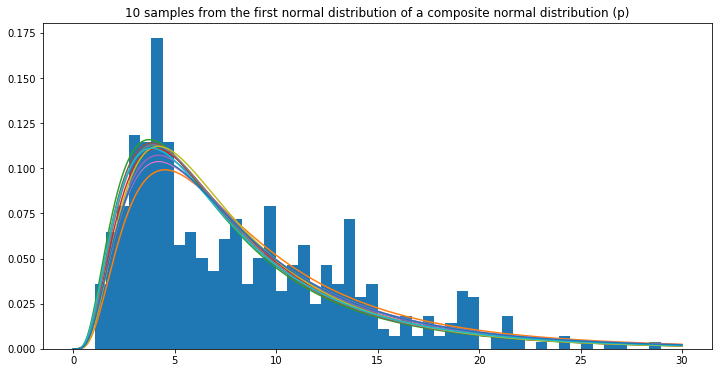

In [80]:
# Plot the normal distributions corresponding to the samples from the first 
# Gaussian distribution (p)

plt.figure(figsize=(12, 6))
plt.hist(hrtem_data, bins=50, density=True)
plot_x = np.linspace(0, 30, 500)
for i in range(10):
  plot_y = sts.lognorm.pdf(plot_x, np.sqrt(sigma1_samples[i]), scale=np.exp(x1_samples[i]))
  plt.plot(plot_x, plot_y)
plt.title('%i samples from the first normal distribution of a composite normal distribution (p)' % 10)
plt.show()

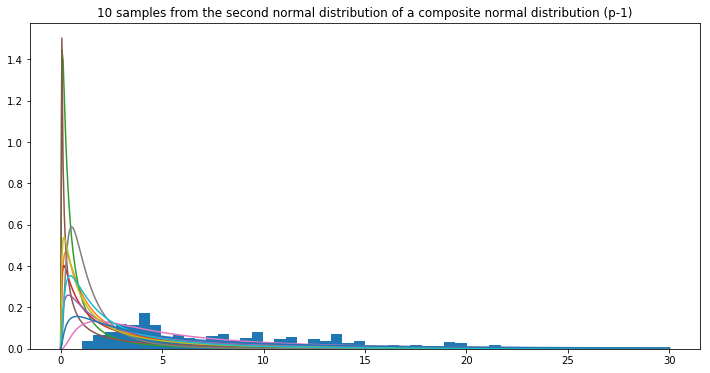

In [81]:
# Plot the normal distributions corresponding to the samples from the second 
# Gaussian distribution (p-1)

plt.figure(figsize=(12, 6))
plt.hist(hrtem_data, bins=50, density=True)
plot_x = np.linspace(0, 30, 500)
for i in range(10):
  plot_z = sts.lognorm.pdf(plot_x, np.sqrt(sigma2_samples[i]), scale=np.exp(x2_samples[i]))
  plt.plot(plot_x, plot_z)
plt.title('%i samples from the second normal distribution of a composite normal distribution (p-1)' % 10)
plt.show()

As you can see from the graphs above, it is obvious that the first Gaussian distribution models the original ``hrtem`` dataset much better than the second Gaussian distribution.

This makes sense, since if we take a look at the distribution of p in  ``stan_results_4`` tab above, the values of p are greatly skewed towards the left, meaning that there are more values on the right  end of the ``0-1`` spectrum. This tells us that there are more values of p that are bigger than ``0.5``, which means that if we take a random sample, there's a higher chance that it is coming from the first Gaussian, which is affiliated to ``p``, as opposed to the second, which is affiliated with ``(1-p)``. 

Therefore, it makes sense that the second Gaussian has a much lower chance of being sampled, since it doesn't really model the dataset as well as the first Gaussian does.
